# TP 1: LDA/QDA y optimización matemática de modelos

# Intro teórica

## Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

## Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

## LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

## Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

## Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

# Código provisto

Con el fin de no retrasar al alumno con cuestiones estructurales y/o secundarias al tema que se pretende tratar, se provee una base de código que **no es obligatoria de usar** pero se asume que resulta resulta beneficiosa.

In [56]:
import numpy as np
import pandas as pd
import numpy.linalg as LA
from scipy.linalg import cholesky, solve_triangular
from scipy.linalg.lapack import dtrtri

## Base code

In [57]:
class BaseBayesianClassifier:
  def __init__(self):
    pass

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    #print("a_priori shape= ", a_priori.shape)
    #print("a_priori= ", a_priori)
    # Q3: para que sirve bincount?
    # R3: Crea un vector con la cantidad de ocurrencias de cada entero dentro de y
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?
    # R4: porque el _fit_params depende de la priori, y la priori se calcula antes

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=int)
    #print("y_hat shape= ", y_hat.shape)
    #print("y_hat= ", y_hat)

    for i in range(m_obs):
      y_hat[i] = self._predict_one(X[:,i].reshape(-1,1))

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]
    # return the class that has maximum a posteriori probability
    #print("log_posteriori= ", log_posteriori)
    return np.argmax(log_posteriori)

In [58]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    # print("y.flatten", y.flatten())
    self.inv_covs = [LA.inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # R5: porque y es un vector columna y no se puede comparar con un vector fila. 
    # Flatten en este caso lo convierte en arreglo de 1D y entonces si se puede hacer la comparacion con idx.
    # Q6: por que se usa bias=True en vez del default bias=False?
    # R6: porque bias=False hace que la matriz de covarianza sea insesgada.

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?
    # R7: axis=1 indica que el promedio se debe calcular por columnas y no por filas.

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(LA.det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [59]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [60]:
class QDA_Chol1(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.L_invs = [
        LA.inv(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True))
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = L_inv @ unbiased_x

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()

In [61]:
class QDA_Chol2(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.Ls = [
        cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True)
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L = self.Ls[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = solve_triangular(L, unbiased_x, lower=True)

    return -np.log(L.diagonal().prod()) -0.5 * (y**2).sum()

In [62]:
class QDA_Chol3(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.L_invs = [
        dtrtri(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True), lower=1)[0]
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = L_inv @ unbiased_x

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()

## Datasets

In [63]:
from sklearn.datasets import load_iris, fetch_openml, load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins_dataset():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

def get_wine_dataset():
    # get data
    data = load_wine()
    X_full = data.data
    y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
    return X_full, y_full

def get_letters_dataset():
    # get data
    letter = fetch_openml('letter', version=1, as_frame=False)
    return letter.data, letter.target.reshape(-1,1)

def label_encode(y_full):
    return LabelEncoder().fit_transform(y_full.flatten()).reshape(y_full.shape)

def split_transpose(X, y, test_size, random_state):
    # X_train, X_test, y_train, y_test but all transposed
    return [elem.T for elem in train_test_split(X, y, test_size=test_size, random_state=random_state)]

## Benchmarking

Nota: esta clase fue creada bastante rápido y no pretende ser una plataforma súper confiable sobre la que basarse, sino más bien una herramienta simple con la que poder medir varios runs y agregar la información.

En forma rápida, `warmup` es la cantidad de runs para warmup, `mem_runs` es la cantidad de runs en las que se mide el pico de uso de RAM y `n_runs` es la cantidad de runs en las que se miden tiempos.

La razón por la que se separan es que medir memoria hace ~2.5x más lento cada run, pero al mismo tiempo se estabiliza mucho más rápido.

**Importante:** tener en cuenta que los modelos que predicen en batch (usan `predict` directamente) deberían consumir, como mínimo, $n$ veces la memoria de los que predicen por observación.

In [64]:
import time
from tqdm.notebook import tqdm
from numpy.random import RandomState
import tracemalloc

RNG_SEED = 6553

class Benchmark:
    def __init__(self, X, y, n_runs=1000, warmup=100, mem_runs=100, test_sz=0.3, rng_seed=RNG_SEED, same_splits=True):
        self.X = X
        self.y = y
        self.n = n_runs
        self.warmup = warmup
        self.mem_runs = mem_runs
        self.test_sz = test_sz
        self.det = same_splits
        if self.det:
            self.rng_seed = rng_seed
        else:
            self.rng = RandomState(rng_seed)

        self.data = dict()

        print("Benching params:")
        print("Total runs:",self.warmup+self.mem_runs+self.n)
        print("Warmup runs:",self.warmup)
        print("Peak Memory usage runs:", self.mem_runs)
        print("Running time runs:", self.n)
        approx_test_sz = int(self.y.size * self.test_sz)
        print("Train size rows (approx):",self.y.size - approx_test_sz)
        print("Test size rows (approx):",approx_test_sz)
        print("Test size fraction:",self.test_sz)

    def bench(self, model_class, **kwargs):
        name = model_class.__name__
        time_data = np.empty((self.n, 3), dtype=float)  # train_time, test_time, accuracy
        mem_data = np.empty((self.mem_runs, 2), dtype=float)  # train_peak_mem, test_peak_mem
        rng = RandomState(self.rng_seed) if self.det else self.rng


        for i in range(self.warmup):
            # Instantiate model with error check for unsupported parameters
            model = model_class(**kwargs)

            # Generate current train-test split
            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )
            # Run training and prediction (timing or memory measurement not recorded)
            model.fit(X_train, y_train)
            model.predict(X_test)

        for i in tqdm(range(self.mem_runs), total=self.mem_runs, desc=f"{name} (MEM)"):

            model = model_class(**kwargs)

            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )

            tracemalloc.start()

            t1 = time.perf_counter()
            model.fit(X_train, y_train)
            t2 = time.perf_counter()

            _, train_peak = tracemalloc.get_traced_memory()
            tracemalloc.reset_peak()

            model.predict(X_test)
            t3 = time.perf_counter()
            _, test_peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            mem_data[i,] = (
                train_peak / (1024 * 1024),
                test_peak / (1024 * 1024)
            )

        for i in tqdm(range(self.n), total=self.n, desc=f"{name} (TIME)"):
            model = model_class(**kwargs)

            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )

            t1 = time.perf_counter()
            model.fit(X_train, y_train)
            t2 = time.perf_counter()
            preds = model.predict(X_test)
            t3 = time.perf_counter()

            time_data[i,] = (
                (t2 - t1) * 1000,
                (t3 - t2) * 1000,
                (y_test.flatten() == preds.flatten()).mean()
            )

        self.data[name] = (time_data, mem_data)

    def summary(self, baseline=None):
        aux = []
        for name, (time_data, mem_data) in self.data.items():
            result = {
                'model': name,
                'train_mean_ms': time_data[:, 0].mean(),
                'train_std_ms': time_data[:, 0].std(),
                'test_mean_ms': time_data[:, 1].mean(),
                'test_std_ms': time_data[:, 1].std(),
                'mean_accuracy': time_data[:, 2].mean(),
                'train_mem_mean_mb': mem_data[:, 0].mean(),
                'train_mem_std_mb': mem_data[:, 0].std(),
                'test_mem_mean_mb': mem_data[:, 1].mean(),
                'test_mem_std_mb': mem_data[:, 1].std()
            }
            aux.append(result)
        df = pd.DataFrame(aux).set_index('model')

        if baseline is not None and baseline in self.data:
            df['train_speedup'] = df.loc[baseline, 'train_mean_ms'] / df['train_mean_ms']
            df['test_speedup'] = df.loc[baseline, 'test_mean_ms'] / df['test_mean_ms']
            df['train_mem_reduction'] = df.loc[baseline, 'train_mem_mean_mb'] / df['train_mem_mean_mb']
            df['test_mem_reduction'] = df.loc[baseline, 'test_mem_mean_mb'] / df['test_mem_mean_mb']
        return df

## Ejemplo

In [65]:
# levantamos el dataset Wine, que tiene 13 features y 178 observaciones en total
X_full, y_full = get_wine_dataset()

X_full.shape, y_full.shape

((178, 13), (178, 1))

In [66]:
# encodeamos a número las clases
y_full_encoded = label_encode(y_full)
print("y_full shape= ", y_full.shape)
print("y_full_encoded shape= ", y_full_encoded.shape)

y_full[:5], y_full_encoded[:5]

y_full shape=  (178, 1)
y_full_encoded shape=  (178, 1)


(array([['class_0'],
        ['class_0'],
        ['class_0'],
        ['class_0'],
        ['class_0']], dtype='<U7'),
 array([[0],
        [0],
        [0],
        [0],
        [0]], dtype=int64))

In [67]:
# generamos el benchmark
# observar que son valores muy bajos de runs para que corra rápido ahora
#b = Benchmark(
#    X_full, y_full_encoded,
#    n_runs = 2,
#    warmup = 2,
#    mem_runs = 2,
#    test_sz = 0.3,
#    same_splits = False
#)

b = Benchmark(
    X_full, y_full_encoded,
    n_runs=1000,  # Más iteraciones
    warmup=10,   # Más warmup para estabilizar
    mem_runs=100, # Más iteraciones para memoria
    test_sz=0.3,
    same_splits=True,
    rng_seed=6553
)

Benching params:
Total runs: 1110
Warmup runs: 10
Peak Memory usage runs: 100
Running time runs: 1000
Train size rows (approx): 125
Test size rows (approx): 53
Test size fraction: 0.3


In [68]:
# bencheamos un par
to_bench = [QDA]

for model in to_bench:
    b.bench(model)

QDA (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [69]:
# como es una clase, podemos seguir bencheando más después
b.bench(TensorizedQDA)

TensorizedQDA (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [70]:
# hacemos un summary
b.summary()

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb
model,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177


In [71]:
# son muchos datos! nos quedamos con un par nomás
summ = b.summary()

# como es un pandas DataFrame, subseteamos columnas fácil
summ[['train_mean_ms', 'test_mean_ms','mean_accuracy']]

,train_mean_ms,test_mean_ms,mean_accuracy
model,,,
QDA,1.342478,2.173369,0.984556
TensorizedQDA,1.303154,0.945842,0.984556


In [72]:
# podemos setear un baseline para que fabrique columnas de comparación
summ = b.summary(baseline='QDA')

summ

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408,1.000000,1.000000,1.000000,1.000000
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177,1.030176,2.297814,1.003988,0.667505


In [73]:
summ[[
    'train_mean_ms', 'test_mean_ms','mean_accuracy',
    'train_speedup', 'test_speedup',
    'train_mem_reduction', 'test_mem_reduction'
]]

,train_mean_ms,test_mean_ms,mean_accuracy,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,
QDA,1.342478,2.173369,0.984556,1.000000,1.000000,1.000000,1.000000
TensorizedQDA,1.303154,0.945842,0.984556,1.030176,2.297814,1.003988,0.667505


# Consigna QDA

**Notación**: en general notamos

* $k$ la cantidad de clases
* $n$ la cantidad de observaciones
* $p$ la cantidad de features/variables/predictores

**Sugerencia:** combinaciones adecuadas de `transpose`, `stack`, `reshape` y, ocasionalmente, `flatten` y `diagonal` suele ser más que suficiente. Se recomienda **fuertemente* explorar la dimensionalidad de cada elemento antes de implementar las clases.

## Tensorización

En esta sección nos vamos a ocupar de hacer que el modelo sea más rápido para generar predicciones, observando que incurre en un doble `for` dado que predice en forma individual un escalar para cada observación, para cada clase. Paralelizar ambos vía tensorización suena como una gran vía de mejora de tiempos.

### 1) Diferencias entre `QDA`y `TensorizedQDA`

1. ¿Sobre qué paraleliza `TensorizedQDA`? ¿Sobre las $k$ clases, las $n$ observaciones a predecir, o ambas?
2. Analizar los shapes de `tensor_inv_covs` y `tensor_means` y explicar paso a paso cómo es que `TensorizedQDA` llega a predecir lo mismo que `QDA`.

### 2) Optimización

Debido a la forma cuadrática de QDA, no se puede predecir para $n$ observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de $n \times n$ en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

3. Implementar el modelo `FasterQDA` (se recomienda heredarlo de `TensorizedQDA`) de manera de eliminar el ciclo for en el método predict.
4. Mostrar dónde aparece la mencionada matriz de $n \times n$, donde $n$ es la cantidad de observaciones a predecir.
5. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de $n \times n$ usando matrices de $n \times p$. También se puede usar, de forma equivalente,
$$
np.sum(A^T \odot B, axis=0).T
$$
  queda a preferencia del alumno cuál usar.

6. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente en un nuevo modelo `EfficientQDA`.
7. Comparar la performance de las 4 variantes de QDA implementadas hasta ahora (no Cholesky) ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Cholesky

Hasta ahora todos los esfuerzos fueron enfocados en realizar una predicción más rápida. Los tiempos de entrenamiento (teóricos al menos) siguen siendo los mismos o hasta (minúsculamente) peores, dado que todas las mejoras siguen llamando al método `_fit_params` original de `QDA`.

La descomposición/factorización de [Cholesky](https://en.wikipedia.org/wiki/Cholesky_decomposition#Statement) permite factorizar una matriz definida positiva $A = LL^T$ donde $L$ es una matriz triangular inferior. En particular, si bien se asume que $p \ll n$, invertir la matriz de covarianzas $\Sigma$ para cada clase impone un cuello de botella que podría alivianarse. Teniendo en cuenta que las matrices de covarianza son simétricas y salvo degeneración, definidas positivas, Cholesky como mínimo debería permitir invertir la matriz más rápido.

*Nota: observar que calcular* $A^{-1}b$ *equivale a resolver el sistema* $Ax=b$.

### 3) Diferencias entre implementaciones de `QDA_Chol`

8. Si una matriz $A$ tiene fact. de Cholesky $A=LL^T$, expresar $A^{-1}$ en términos de $L$. ¿Cómo podría esto ser útil en la forma cuadrática de QDA?
9. Explicar las diferencias entre `QDA_Chol1`y `QDA` y cómo `QDA_Chol1` llega, paso a paso, hasta las predicciones.
10. ¿Cuáles son las diferencias entre `QDA_Chol1`, `QDA_Chol2` y `QDA_Chol3`?
11. Comparar la performance de las 7 variantes de QDA implementadas hasta ahora ¿Qué se observa?¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás?¿Alguna que sea peor?

### 4) Optimización

12. Implementar el modelo `TensorizedChol` paralelizando sobre clases/observaciones según corresponda. Se recomienda heredarlo de alguna de las implementaciones de `QDA_Chol`, aunque la elección de cuál de ellas queda a cargo del alumno según lo observado en los benchmarks de puntos anteriores.
13. Implementar el modelo `EfficientChol` combinando los insights de `EfficientQDA` y `TensorizedChol`. Si se desea, se puede implementar `FasterChol` como ayuda, pero no se contempla para el punto.
13. Comparar la performance de las 9 variantes de QDA implementadas ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

# Resolución del TP

### 1) ¿Sobre qué paraleliza TensorizedQDA? ¿Sobre las $k$ clases, las $n$ observaciones a predecir, o ambas?

TensorizedQDA paraleliza sobre las $k$ clases.

En el modelo QDA original, *predict_log_conditional* actuaba para cada clase individualmente. Al tensorizar las operaciones (con tensor_inv_cov y tensor_means), se calculan las log-probabilidades condicionales de todas las clases simultáneamente, eliminando el for loop de *predict_one* con el que operaba sobre las clases y aprovechando el paralelismo implícito de las operaciones matriciales en bibliotecas como Numpy.

Cabe aclarar que este paralelismo es sobre las clases y no sobre las observaciones, ya que éstas aún se procesan una por una en el método predict.


En forma gráfica, QDA procesa un vector de features a la vez de la siguiente forma:

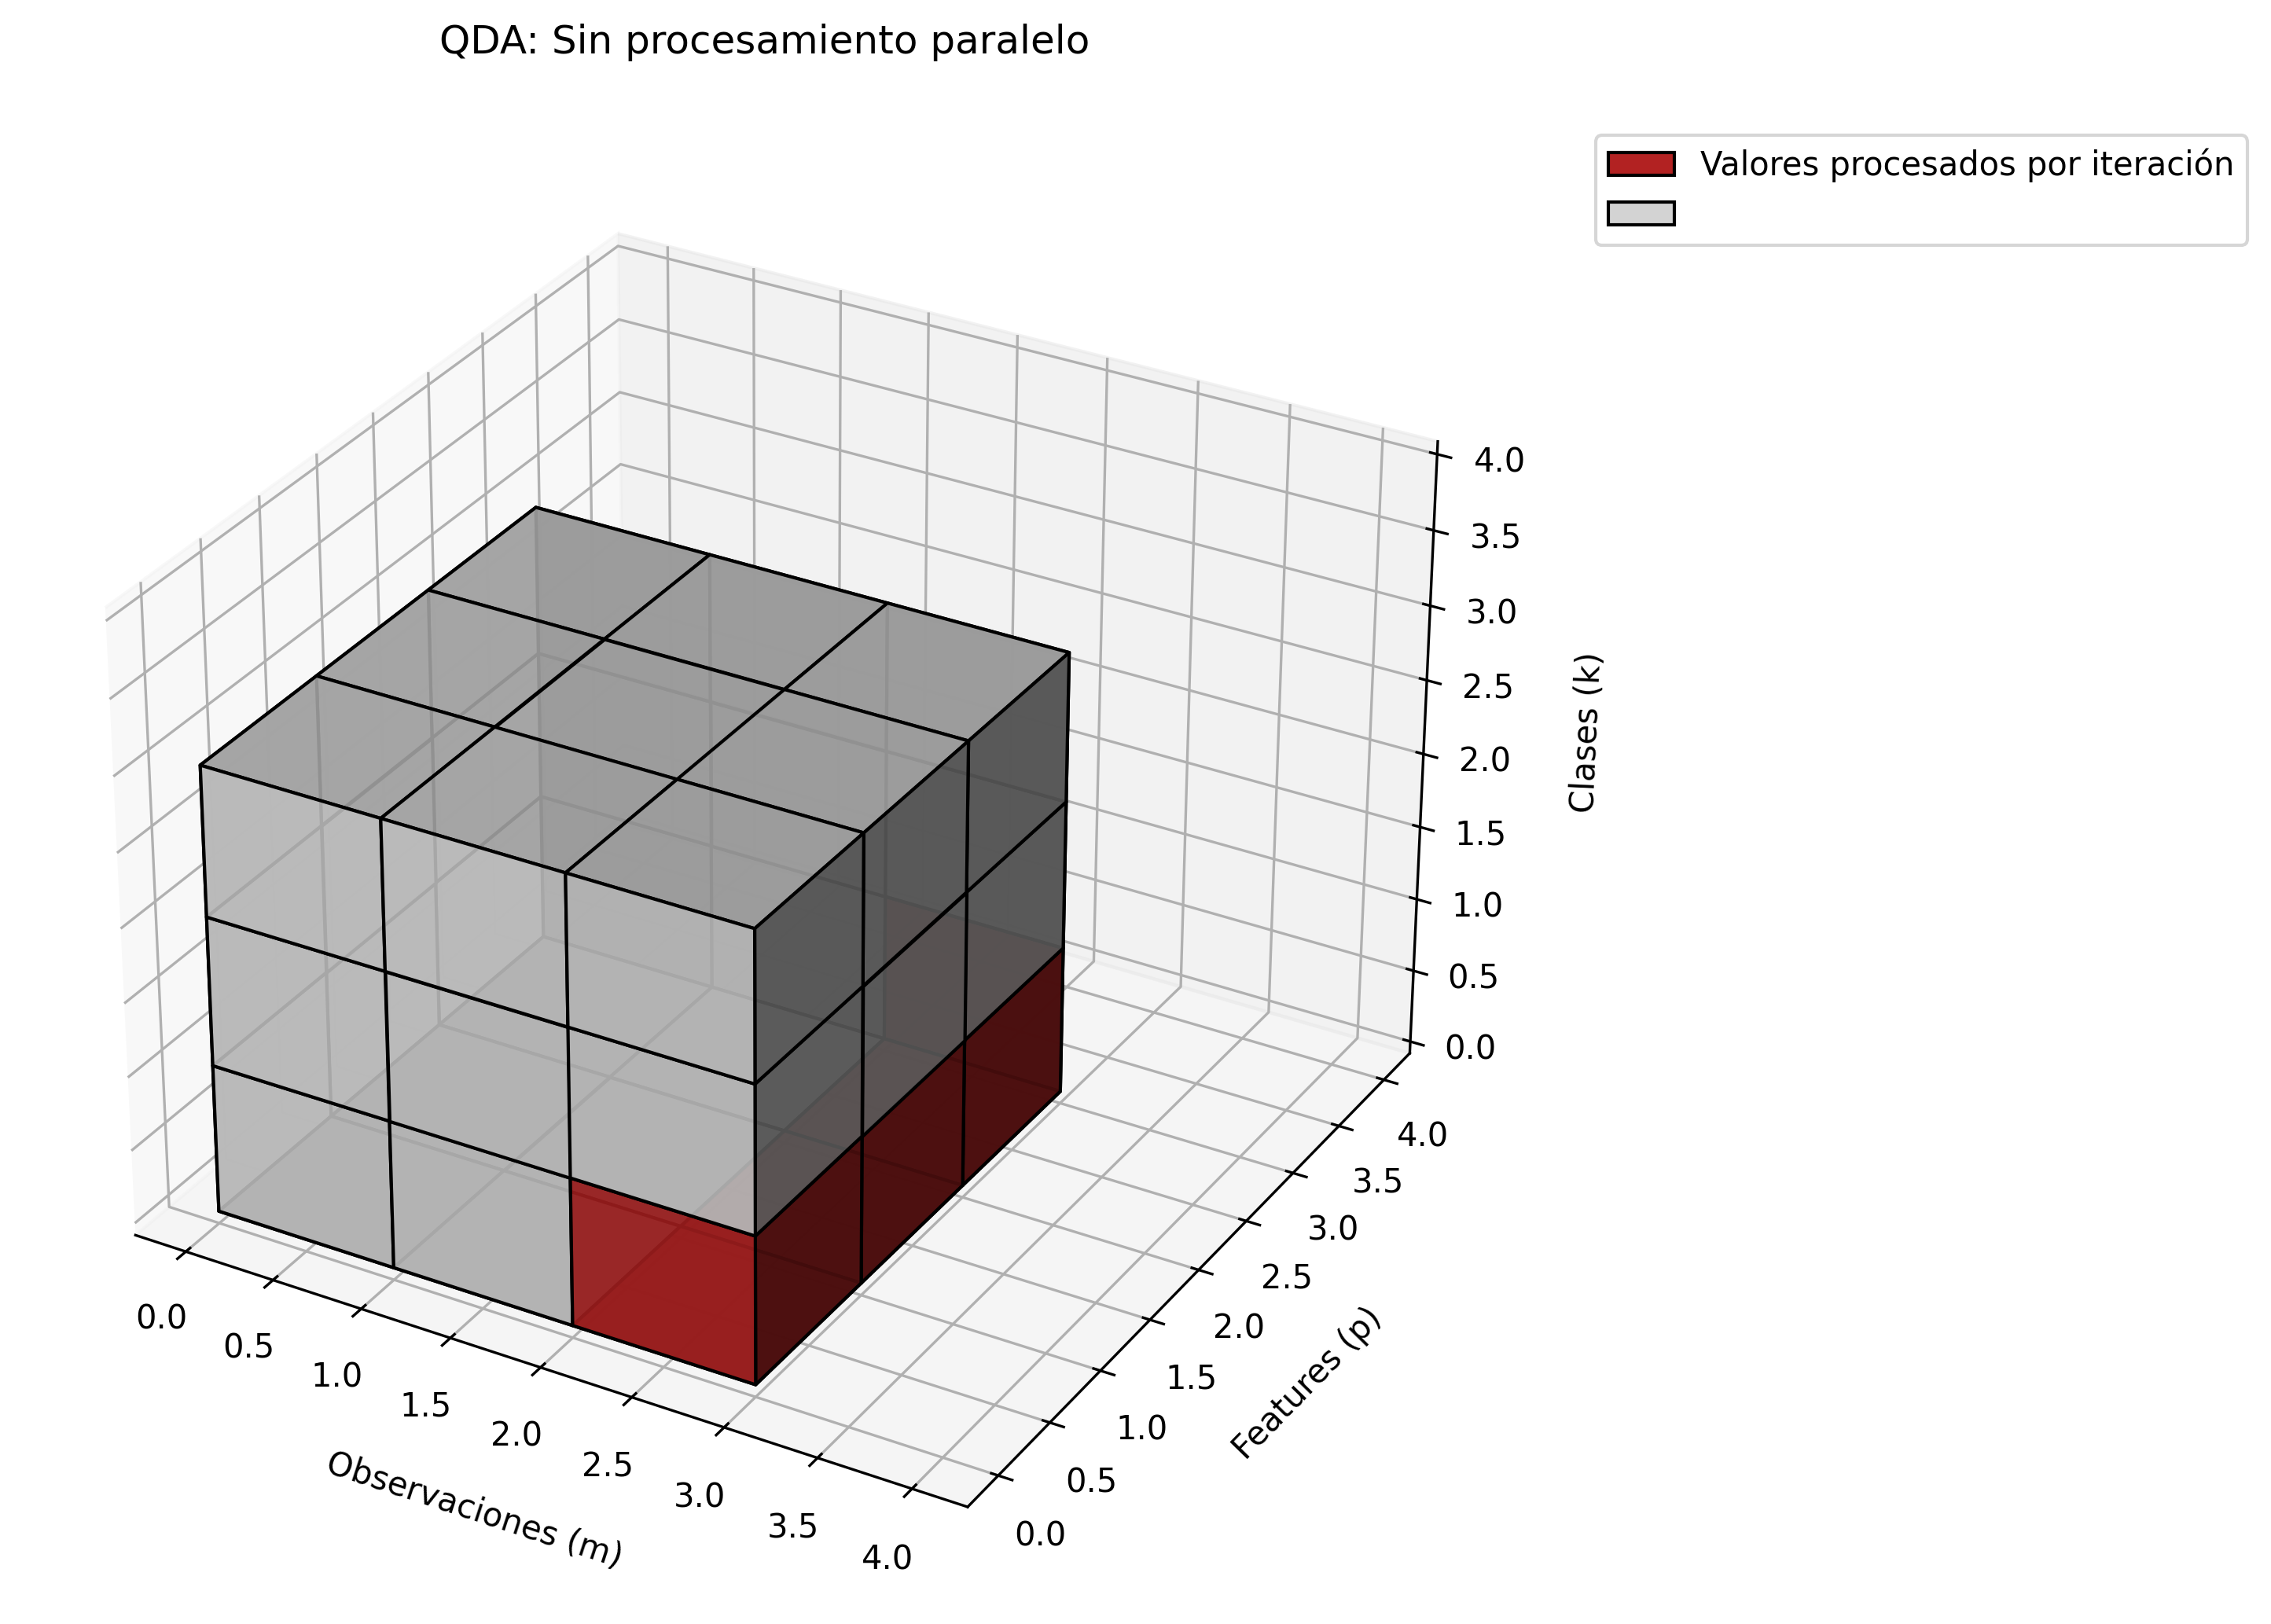

In [74]:
from IPython.display import Image, display

display(Image(filename="QDA - Sin procesamiento paralelo.png"))

Mientras que TensorizedQDA tensoriza sobre las clases:

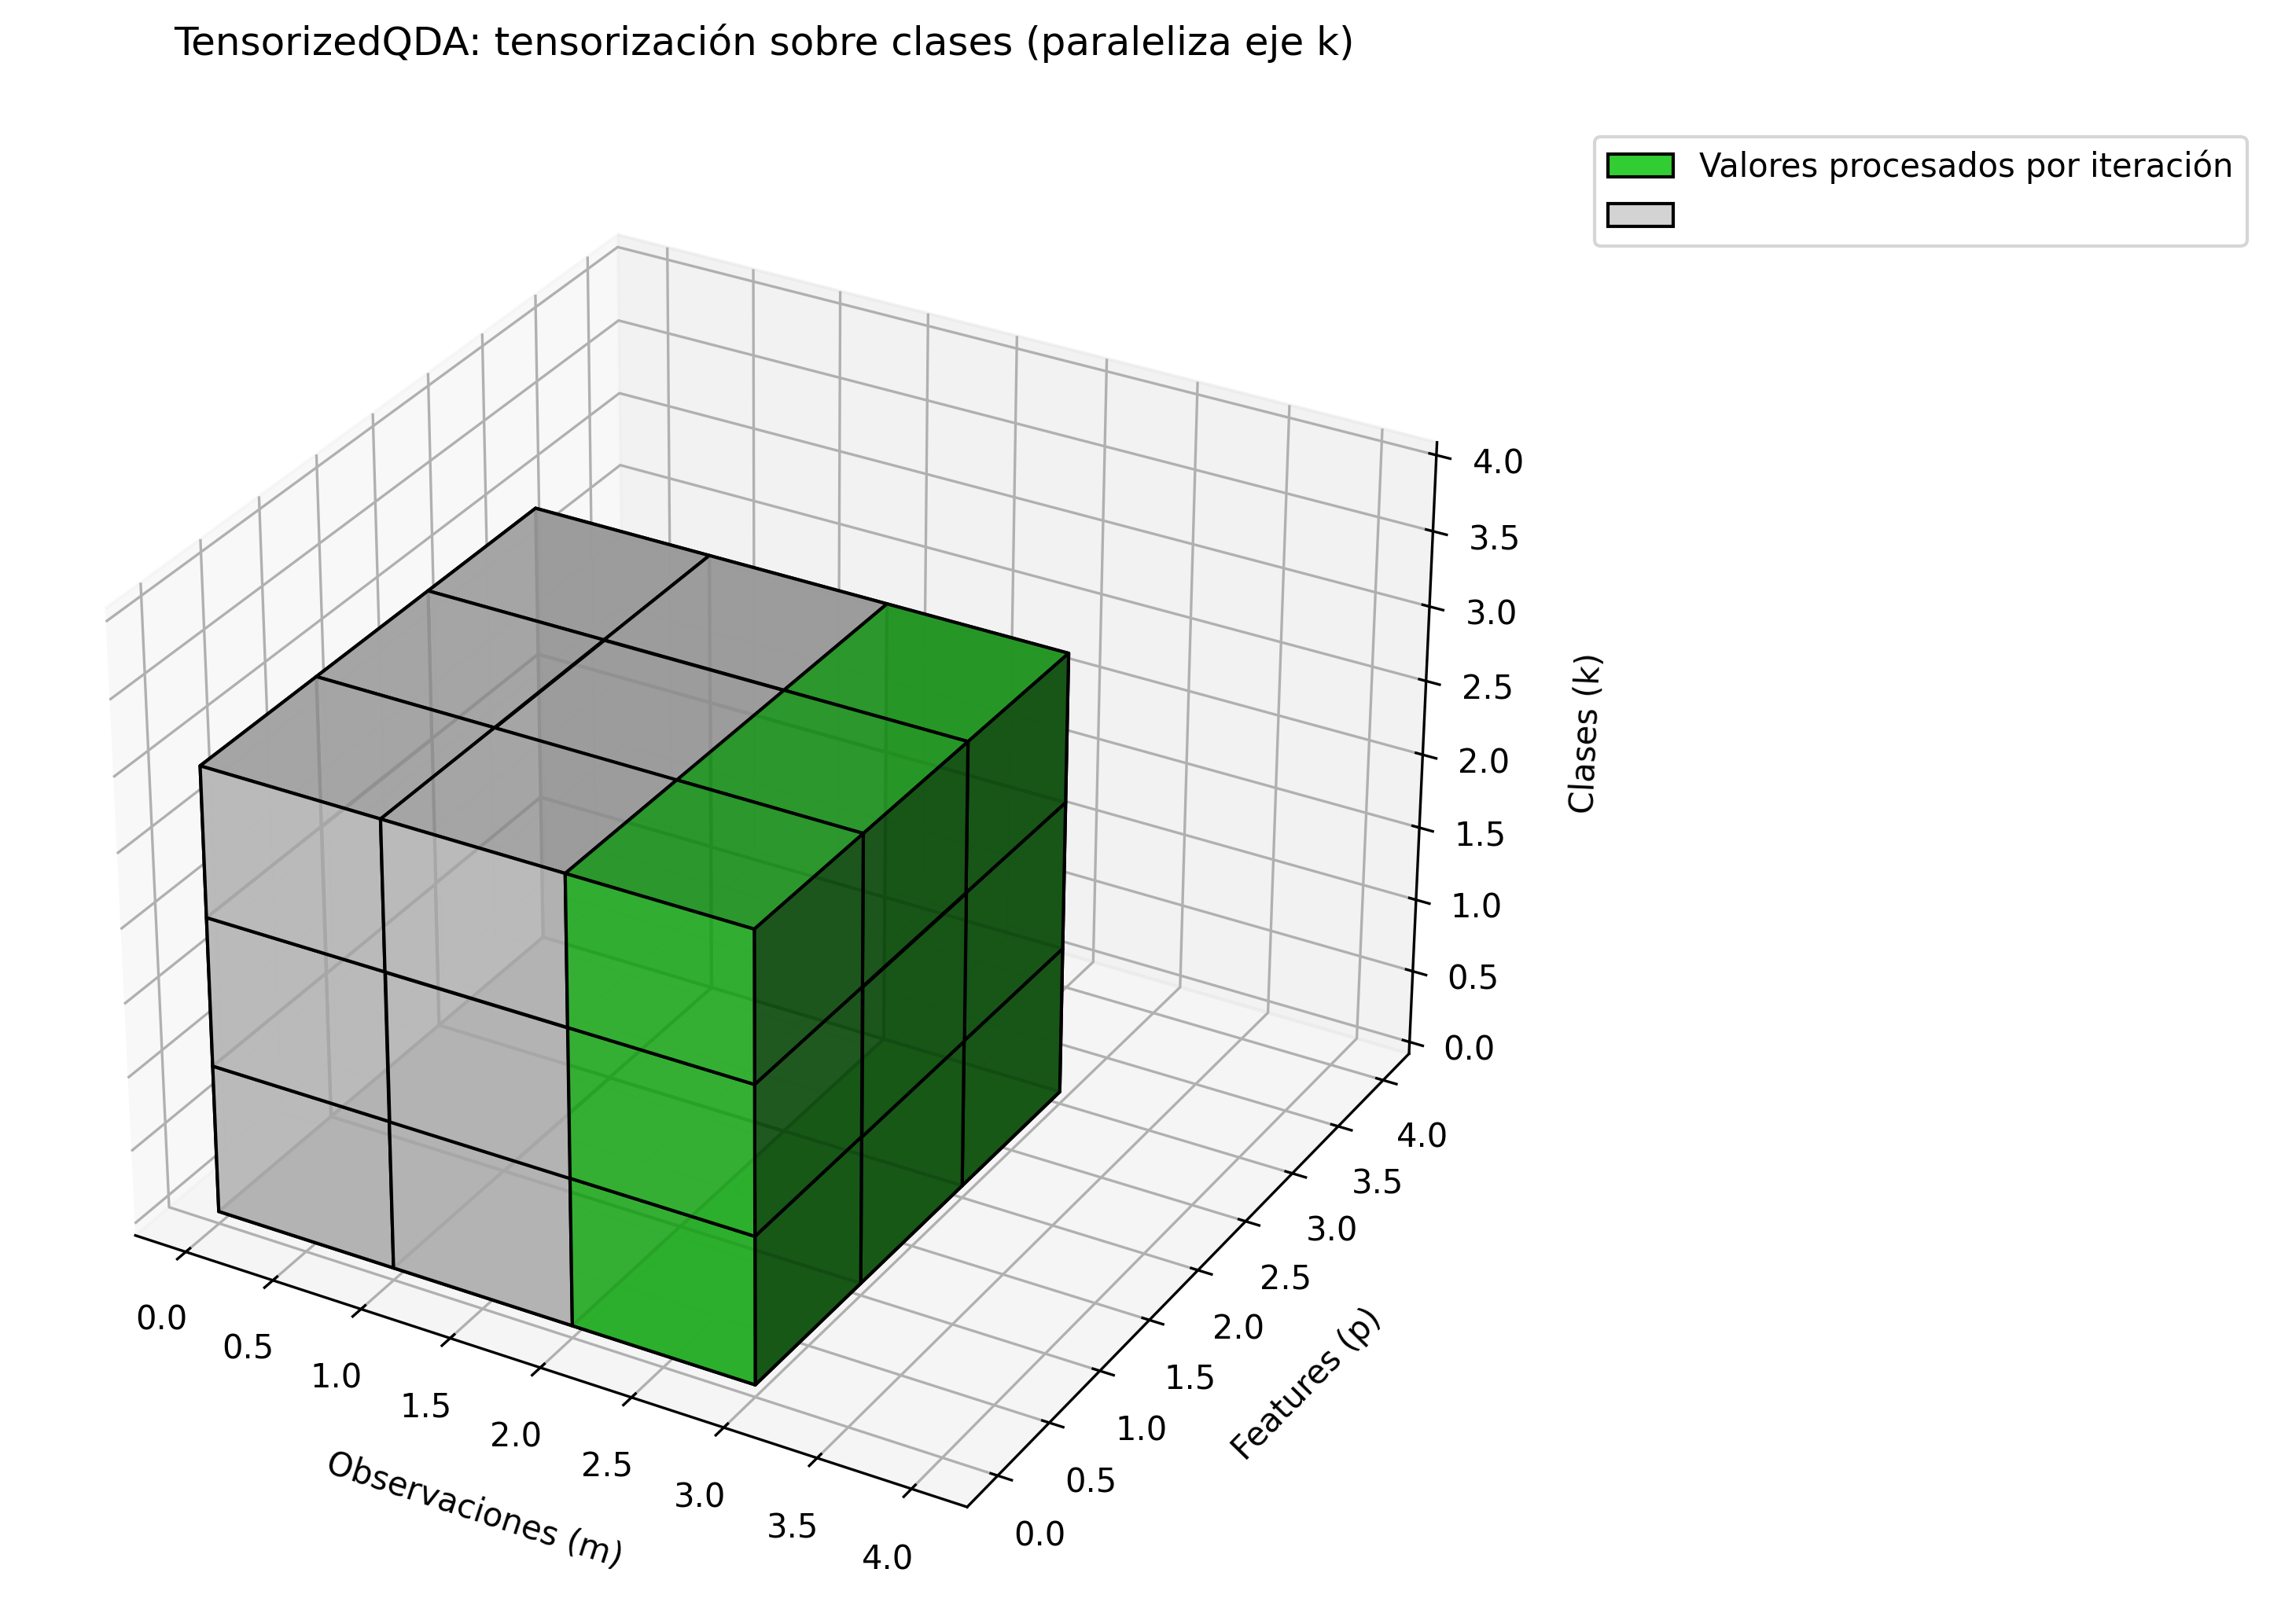

In [75]:
display(Image(filename="TensorizedQDA - tensorización sobre clases (paraleliza eje k).png"))

### 2. Analizar los shapes de tensor_inv_covs y tensor_means y explicar paso a paso cómo es que TensorizedQDA llega a predecir lo mismo que QDA.

- **Shapes esperados**:
  - tensor_means: Shape $(k, p, 1)$, donde $k$ es el número de clases y $p$ es el número de features. Representa los vectores de medias para cada clase, organizados como vectores columna.
  *En este caso, 3 clases y 13 features, (3,13,1). Se calcula una media para feature y para cada clase.* 
  
  - tensor_inv_covs: Shape $(k, p, p)$, donde cada "capa" $(p, p)$ es la matriz inversa de la covarianza para una clase específica.
  *En este caso, (3,13,13). Para cada clase genera una matriz cuadrada de las covarianzas entre cada feature (siendo la diagonal la varianza propia de la feature).*

- **Paso a paso en TensorizedQDA**:

  1. **Entrada**: Se recibe una observación $x$ de shape $(p, 1)$, que se desea clasificar. 
  *En este caso, (13,1).*

  2. **Diferencia con las medias**: Se calcula $X - \mu_k$ para cada clase $k$. Gracias al broadcasting, se puede restar tensor_means de shape $(k, p, 1)$ a $x$ de shape $(p,1)$, resultando en una matriz de diferencias de shape $(k, p, 1)$.
  *En este caso, (13,1) - (3,13,1) = (3,13,1)*

  3. **Forma cuadrática**: Para cada clase $k$, se necesita calcular $(x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k)$. En TensorizedQDA, esto se realiza con: unbiased_x.transpose(0, 2, 1) @ tensor_inv_covs @ unbiased_x
  donde:

      - unbiased_x.transpose(0,2,1) de shape $(k, 1, p)$, *aquí (3,1,13)*
      - tensor_inv_covs de shape $(k, p, p)$, *aquí (3,13,13)*
      - unbiased_x de shape $(k, p, 1)$, *aquí (3,13,1)* 

  Para la primera multiplicación, internamente multiplica los 3 vectores de (1,13) por las 3 matrices de (13,13) y las vuelve a apilar. De esta forma, funciona igual que el for loop que lo hacía en forma separada para las 3, pero numpy lo hace en forma más eficiente al poder paralelizar la operación. El resultado es un tensor de (3,1,13), que luego es multiplicado por (3,13,1), resultando en un tensor de (3,1,1).
  Finalmente, entonces, esta multiplicación matricial da como resultado un tensor de shape $(k, 1, 1)$, que contiene el valor cuadrático para cada clase. Esto corresponde al segundo término de la log verosimilitud para cada una de las clases (al multiplicar por -0.5).

  4. **Términos adicionales**: Se suman a cada término cuadrático:
      - Los logaritmos de los determinantes de las matrices de covarianza, calculados con np.log(LA.det(self.tensor_inv_cov)). tensor_inv_cov es de $(k, p, p)$, *en este caso (3,13,13)*. La función det genera el determinante de las matrices de *(13,13)* para cada una de las 3 clases, dando como resultado de shape $(k,1)$ o *(3,1)*. Esto se reacomoda (por broadcasting), se multiplica por 0.5 y se suma a los valores anteriores, dando las log-verosimilitudes condicionales completas para cada clase.
      - Los logaritmos de las probabilidades a priori (log_a_priori), de shape $(k,)$.
       
  5. **Predicción**: Se suman todos los términos y se toma el argmax sobre la dimensión de clases (eje 0 del tensor de shape $(k, 1, 1)$, *en este caso (3,1,1)*) para seleccionar la clase con mayor verosimilitud, obteniendo la predicción final. Si se aplica a múltiples observaciones, el resultado final tiene shape $(n,)$, igual que en QDA.
  

- **Equivalencia**: La tensorización conserva exactamente la misma la fórmula matemática del discriminante cuadrático usada por QDA. La diferencia radica en cómo se realizan los cálculos: utiliza operaciones vectorizadas sobre tensores para evitar bucles explícitos, logrando el mismo resultado que QDA con una mayor eficiencia computacional.

### 3. Implementar el modelo FasterQDA (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.

El siguiente código elimina el bucle explícito sobre observaciones al tensorizar en las observaciones para calcular la forma cuadrática en una sola operación.

In [76]:
class FasterQDA(TensorizedQDA):
    def predict(self, X):
        m_obs = X.shape[1]
        k_classes = len(self.log_a_priori)
        
        # Calcular las log-posteriori para todas las observaciones y clases
        log_posteriori = np.empty((k_classes, m_obs))
        
        # Diferencia entre X y la media de la clase k
        unbiased_X = X - self.tensor_means
        # Esto genera una tensor de (k_clases, m_obs, m_obs)
        inner_prod = unbiased_X.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_X
        # Extraer solo la diagonal (log-probabilidad condicional para cada observación)
        log_conditional = 0.5 * np.log(LA.det(self.tensor_inv_cov)).reshape(-1, 1) - 0.5 * np.diagonal(inner_prod, axis1=1, axis2=2)
        # Sumar el log a priori
        log_posteriori = self.log_a_priori.reshape(-1, 1) + log_conditional
        
        # Elegir la clase con máxima probabilidad log-posteriori
        y_hat = np.argmax(log_posteriori, axis=0)
        return y_hat.reshape(1, -1)

De forma gráfica, ahora los X son tensores sobre las p features, k_clases y m_obs

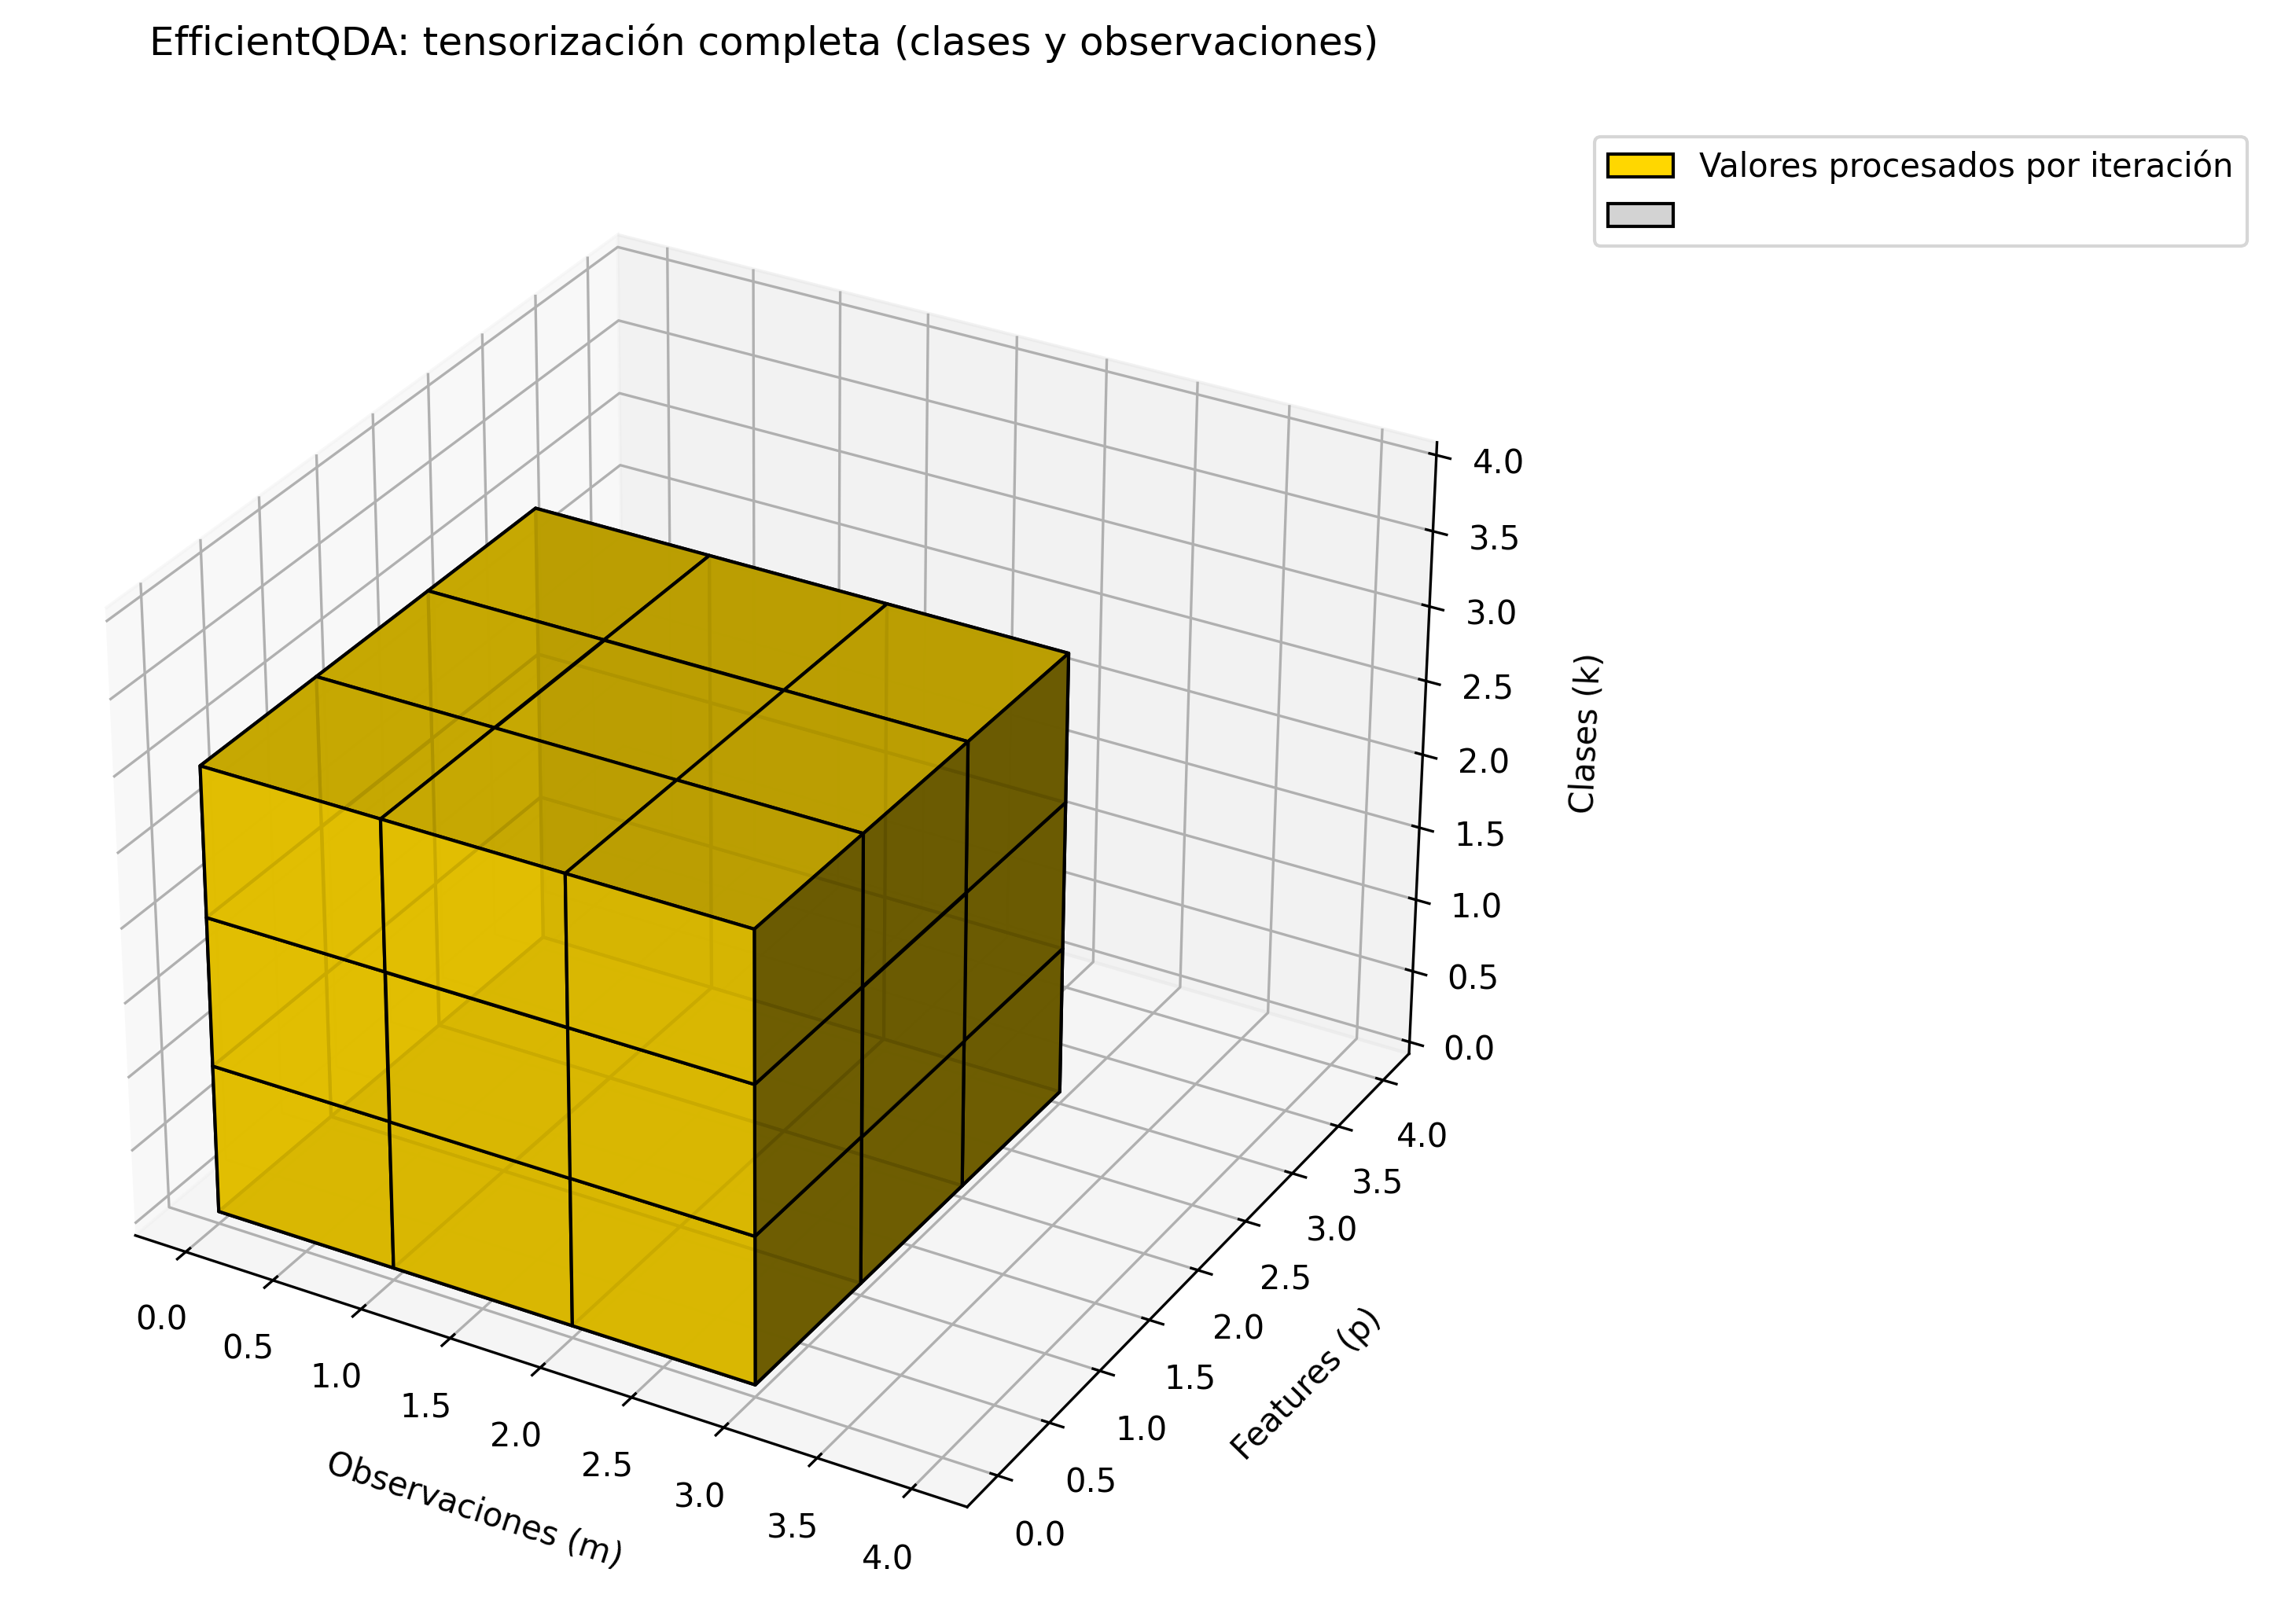

In [77]:
display(Image(filename="EfficientQDA - tensorización completa (clases y observaciones).png"))

Una alternativa que evita trabajar directamente con una matriz de tamaño $n$ x $n$ es aprovechar cómo funciones de NumPy, como det() o la multiplicación de matrices, manejan los tensores. Estas funciones tratan las últimas dos dimensiones del tensor como las dimensiones de las submatrices, y realizan las operaciones en paralelo a lo largo de las primeras dimensiones. Por ejemplo, si tengo un tensor de forma (x, y, w, z) y calculo el determinante, este se aplica a cada submatriz de forma (w, z), paralelizándose a lo largo de los ejes x e y.
De esta forma, si las primeras dos dimensiones del tensor son las m_obs y los n_features, que son los loops que se buscan eliminar, las operaciones realizadas son las mismas que en `QDA` pero de forma más rápida gracias a que se ejecutan en paralelo.

In [78]:
class FasterQDA_v2(TensorizedQDA):
    #Implementación sin la matriz de nxn
    def _predict_log_conditionals(self,X):
        X = X.T # Pasar las observaciones a filas (m_obs, n_features)
        # Dado que debe hacer a la vez un broadcasting de X para las k clases, y tensor_means para las m_obs, hacemos el broadcasting de X explícito
        X = X.reshape(X.shape[0], X.shape[1],1) # Agregar 3ra dimension (m_obs, n_features, 1)
        X_expandido = np.expand_dims(X, axis=1)  # (m_obs, 1, n_features, 1)
        X_expandido = np.repeat(X_expandido, repeats=len(self.log_a_priori), axis=1)  # len(self.log_a_priori) es la cantidad de clases. Replica el vector para cada clase (m_obs, k_clases, n_features, 1)
        unbiased_X = X_expandido - self.tensor_means 
        inner_prod = unbiased_X.transpose(0,1,3,2) @ self.tensor_inv_cov @ unbiased_X
        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.squeeze()

    def _predict_one(self, X):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(X), axis =1)
    
    def predict(self, X):
        # this is actually an individual prediction encased in a for-loop
        y_hat = self._predict_one(X)

        # return prediction as a row vector (matching y)
        return y_hat.reshape(1,-1)

In [79]:
b.bench(FasterQDA)

FasterQDA (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [80]:
b.bench(FasterQDA_v2)

FasterQDA_v2 (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

FasterQDA_v2 (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [81]:
b.summary()

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb
model,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177
FasterQDA,1.282619,0.261045,0.064105,0.030496,0.984556,0.018221,0.000945,0.110501,0.000186
FasterQDA_v2,1.278193,0.209205,0.069631,0.019093,0.984556,0.018211,0.000928,0.060188,0.000217


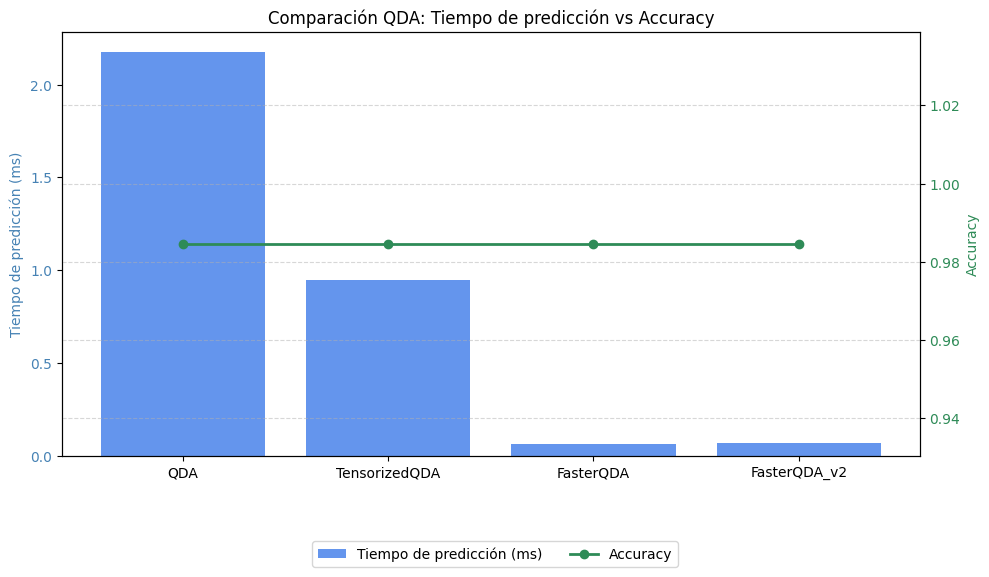

In [82]:
# -- Gráficos de comparación
import matplotlib.pyplot as plt

# Obtener el summary directamente desde el benchmark
df_summary = b.summary()

# Extraer columnas de interés
tiempos = df_summary["test_mean_ms"]
accuracies = df_summary["mean_accuracy"]

# Crear gráfico combinado
fig, ax1 = plt.subplots(figsize=(10, 5))

# Barras: tiempo de predicción
bars = ax1.bar(df_summary.index, tiempos, color='cornflowerblue', label="Tiempo de predicción (ms)")
ax1.set_ylabel("Tiempo de predicción (ms)", color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Línea: accuracy
ax2 = ax1.twinx()
line, = ax2.plot(df_summary.index, accuracies, color='seagreen', marker='o', linewidth=2, label="Accuracy")
ax2.set_ylabel("Accuracy", color='seagreen')
ax2.tick_params(axis='y', labelcolor='seagreen')

# Agregar leyenda combinada (de ambas y-axes)
fig.legend([bars, line], ["Tiempo de predicción (ms)", "Accuracy"], loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2)

# Título y formato
plt.title("Comparación QDA: Tiempo de predicción vs Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### En resumen

Se propusieron dos versiones (`FasterQDA` y `FasterQDA_v2`) que eliminan el ciclo `for` de predicción presente en la implementación clásica `QDA`.

Ambas versiones utilizan **tensorización** para calcular los valores discriminantes cuadráticos para **todas las observaciones y clases en paralelo**, eliminando la necesidad de bucles explícitos y matrices intermedias costosas.

- `FasterQDA` replica vectores de entrada y extrae las diagonales de las formas cuadráticas completas, logrando una ejecución más eficiente.
- `FasterQDA_v2` refina aún más esta lógica, evitando por completo la construcción de matrices \( n \times n \), utilizando `squeeze` y broadcasting controlado para optimizar tanto memoria como velocidad.

#### Observaciones del gráfico:

- **`QDA`** clásico es el más lento, con tiempos promedio de predicción significativamente mayores.
- **`TensorizedQDA`** mejora la eficiencia respecto a `QDA` en cuanto al tiempo de predicción.
- **`FasterQDA`** se observa una mejora significativa en cuanto al tiempo de predicción con respecto a `TensorizedQDA` y `QDA`.
- **`FasterQDA_v2`** se destaca como la mejor versión:  
  - Es **la más rápida** del conjunto. 
  - Se observa una mejora también en cuanto al **uso de memoria** para la predicción en comparación a `FasterQDA`.
- En todos los casos, se observa que la precisión se mantiene constante, independientemente del método utilizado para el cálculo.  

#### Conclusión final:

Ambas versiones propuestas, `FasterQDA` y `FasterQDA_v2`, no solo eliminan los bucles, sino que logran **eficiencia computacional sin comprometer la precisión**.  
En particular, **`FasterQDA_v2`** representa la **mejor combinación de performance y exactitud**, y constituye una solución altamente escalable para problemas de clasificación con QDA.



### 4) Mostrar dónde aparece la mencionada matriz de $n \times n$, donde $n$ es la cantidad de observaciones a predecir.



  - La matriz de $n \times n$ aparece en el término cuadrático si intentamos calcularlo directamente como $(X - M)^T \Sigma^{-1} (X - M)$, donde $X$ es $(n, p)$ y $M$ es una matriz de medias repetidas para cada observación. En FasterQDA, esto ocurre en el tensor denominado inner_product (el tensor queda de la forma (k, n, n))
    - diffs $(n, k, p)$ y tensor_inv_covs $(k, p, p)$ generan un producto intermedio que, si no se reduce inmediatamente, podría interpretarse como una interacción entre todas las $n$ observaciones para cada clase, pero np.diag colapsa esto a $(k, n)$ directamente, evitando materializar la matriz $n \times n$ completa.

#### Ejemplo simple con 3 observaciones

In [83]:
# -- Ejemplo breve con 3 observaciones --
import numpy as np

# Supongamos 3 observaciones con 2 features cada una
X = np.array([
    [1.0, 2.0],
    [0.0, 1.0],
    [2.0, 0.0]
])  # shape (3, 2)

# Media de la clase (fija para todas)
mu = np.array([1.0, 1.0])  # shape (2,)

# Inversa de la matriz de covarianza
Sigma_inv = np.array([
    [1.0, 0.0],
    [0.0, 1.0]
])  # identidad solo para simplificar

# Paso 1: restamos la media (broadcasting)
diff = X - mu  # shape (3, 2)

# Paso 2: construimos la matriz completa (n x n)
# Cada entrada [i, j] es: (x_i - mu)^T Σ^{-1} (x_j - mu)
inner_product_full = diff @ Sigma_inv @ diff.T  # shape (3, 3)
print("Matriz n x n de productos cruzados:")
print(inner_product_full)

# Paso 3: extraemos solo la diagonal (lo que realmente usamos en QDA)
inner_diag = np.diagonal(inner_product_full)  # shape (3,)
print("\nDiagonal (forma cuadrática por observación):")
print(inner_diag)

Matriz n x n de productos cruzados:
[[ 1.  0. -1.]
 [ 0.  1. -1.]
 [-1. -1.  2.]]

Diagonal (forma cuadrática por observación):
[1. 1. 2.]


#### Interpretación del ejemplo

- La matriz 3x3 tiene **productos cruzados innecesarios**.
- La diagonal contiene lo importante:

  $$
  (x_i - \mu)^T \Sigma^{-1} (x_i - \mu)
  $$

- En QDA no necesitamos toda la matriz. Solo usamos los valores diagonales que es la forma cuadrática por observación (score individual).


### 5) **Demostrar que**  $\text{diag}(A \cdot B) = \sum_{\text{cols}} A \odot B^T = \texttt{np.sum}(A \odot B^T, \texttt{axis=1})$

**Prueba:**








Sea $ A \in \mathbb{R}^{n \times k}$  y $B \in \mathbb{R}^{k \times n}$.

El producto $( A \cdot B ) \in \mathbb{R}^{n \times n} $, por lo que su diagonal se define como:

$$
\text{diag}(A \cdot B)_i = \sum_{j=1}^{k} A_{ij} B_{ji}
$$

Esto se deduce directamente de la definición del producto de matrices, ya que:

$$
(A \cdot B)_{ii} = \sum_{j=1}^{k} A_{ij} \cdot B_{ji}
$$

Por lo tanto:

$$
\text{diag}(A \cdot B)_i = \sum_{j=1}^{k} A_{ij} \cdot B_{ji}
$$

Dado que $( B^T \in \mathbb{R}^{n \times k} )$, entonces la multiplicación elemento a elemento  $A \odot B^T \in \mathbb{R}^{n \times k}$ está bien definida.

El elemento en la posición $(i, j)$ de $A \odot B^T$ es:

$$
(A \odot B^T)_{ij} = A_{ij} \cdot B^T_{ij} = A_{ij} \cdot B_{ji}
$$

Entonces, si sumamos cada fila de esta matriz obtenemos:

$$
\sum_{\text{cols}} (A \odot B^T)_i = \sum_{j=1}^{k} A_{ij} \cdot B_{ji}
$$

Lo que equivale a la expresión para $\text{diag}(A \cdot B)_i$

Por lo tanto:

$$
\text{diag}(A \cdot B) = \texttt{np.sum}(A \odot B^T, \texttt{axis=1})
$$

En NumPy, dada una matriz `A` de dimensiones `(n, k)` y `B` con dimensiones `(k, n)`,  
se puede calcular la diagonal de `A @ B` por medio de:

```python
np.sum(A * B.T, axis=1)

Debido a que 
  - A * B.T es la multiplicación elemento a elemento
  - np.sum(..., axis=1) suma a lo largo de las columnas, es decir, fila por fila.

A continuación se incluye un ejemplo en Python para demostrar esta propiedad:

In [84]:
# Ejemplo de cómo calcular la diagonal de A @ B y la suma de filas de A * B.T
# Definimos matrices A (2x3) y B (3x2)
A = np.array([[1, 2, 3],
              [4, 5, 6]])
B = np.array([[7, 8],
              [9, 10],
              [11, 12]])

# Método 1: Diagonal de A @ B
diagonal_AB = np.diag(A @ B)
print("Diagonal de A @ B:", diagonal_AB)

# Método 2: Suma de filas de A * B.T
sum_rows = np.sum(A * B.T, axis=1)
print("Suma de filas de A * B.T:", sum_rows)

# Verificamos que son iguales
print("¿Son iguales?", np.array_equal(diagonal_AB, sum_rows))

Diagonal de A @ B: [ 58 154]
Suma de filas de A * B.T: [ 58 154]
¿Son iguales? True


### 6) Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo FasterQDA de forma eficiente en un nuevo modelo EfficientQDA.

In [85]:
class EfficientQDA(TensorizedQDA):
    def predict(self, X):
        m_obs = X.shape[1]
        k_classes = len(self.log_a_priori)
        
        # Diferencia entre X y la media de la clase k
        unbiased_X = X - self.tensor_means
        # Calcular inv_cov_k @ (X - mu_k)
        cov_unbiased = self.tensor_inv_cov @ unbiased_X
        # Usar la propiedad: suma de (X - mu_k)^T ⊙ (inv_cov_k @ (X - mu_k))
        inner_prod = np.sum(unbiased_X.T * cov_unbiased.T, axis=1)
        # Extraer solo la diagonal (log-probabilidad condicional para cada observación)
        log_conditional = 0.5 * np.log(LA.det(self.tensor_inv_cov)).reshape(-1, 1) - 0.5 * inner_prod.T
        # Sumar el log a priori
        log_posteriori = self.log_a_priori.reshape(-1, 1) + log_conditional
        
        # Elegir la clase con máxima probabilidad log-posteriori
        y_hat = np.argmax(log_posteriori, axis=0)
        return y_hat.reshape(1, -1)

In [86]:
b.bench(EfficientQDA)

EfficientQDA (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [87]:
b.summary()

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb
model,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177
FasterQDA,1.282619,0.261045,0.064105,0.030496,0.984556,0.018221,0.000945,0.110501,0.000186
FasterQDA_v2,1.278193,0.209205,0.069631,0.019093,0.984556,0.018211,0.000928,0.060188,0.000217
EfficientQDA,1.297565,0.283048,0.062518,0.029292,0.984556,0.018202,0.000956,0.076200,0.000185


### 7) Comparar la performance de las 4 variantes de QDA implementadas hasta ahora (no Cholesky) ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

In [88]:
b.summary()

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb
model,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177
FasterQDA,1.282619,0.261045,0.064105,0.030496,0.984556,0.018221,0.000945,0.110501,0.000186
FasterQDA_v2,1.278193,0.209205,0.069631,0.019093,0.984556,0.018211,0.000928,0.060188,0.000217
EfficientQDA,1.297565,0.283048,0.062518,0.029292,0.984556,0.018202,0.000956,0.076200,0.000185


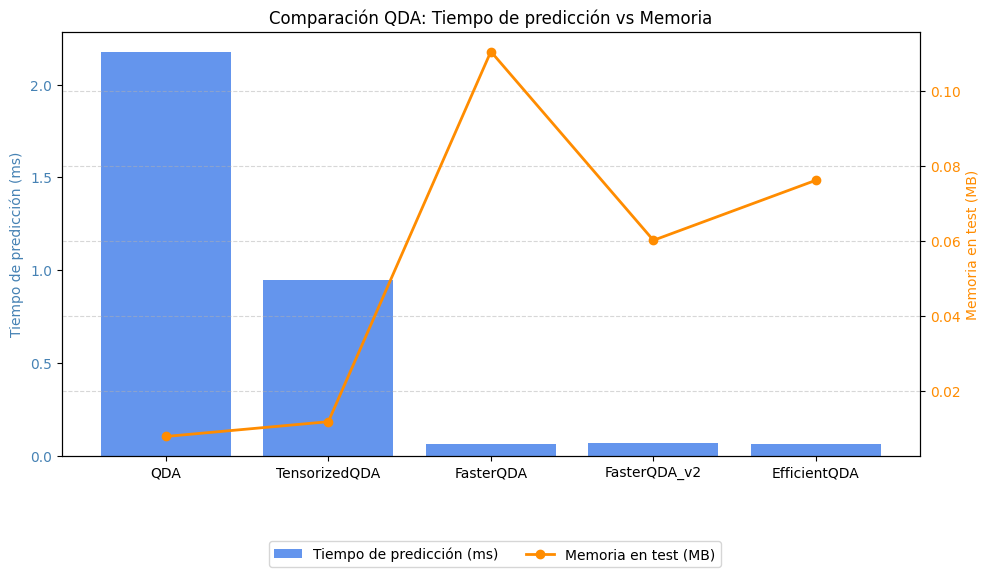

In [89]:
import matplotlib.pyplot as plt

# Obtener resultados del benchmark
df = b.summary()

# Extraer métricas directamente desde el DataFrame
modelos = df.index.tolist()
tiempos = df["test_mean_ms"]
memorias = df["test_mem_mean_mb"]

# Crear gráfico combinado
fig, ax1 = plt.subplots(figsize=(10, 5))

# Barras: tiempo de predicción
bars = ax1.bar(modelos, tiempos, color='cornflowerblue', label="Tiempo de predicción (ms)")
ax1.set_ylabel("Tiempo de predicción (ms)", color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Línea: memoria de predicción
ax2 = ax1.twinx()
line, = ax2.plot(modelos, memorias, color='darkorange', marker='o', linewidth=2, label="Memoria en test (MB)")
ax2.set_ylabel("Memoria en test (MB)", color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Leyenda y título
fig.legend([bars, line], ["Tiempo de predicción (ms)", "Memoria en test (MB)"], loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2)
plt.title("Comparación QDA: Tiempo de predicción vs Memoria")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Interpretación del gráfico:

- El eje izquierdo (barras azules) representa el **tiempo de predicción promedio** en milisegundos para cada modelo de QDA.
- El eje derecho (línea naranja) representa el **consumo promedio de memoria** en MB durante la predicción.
- La comparación visual permite observar **el trade-off entre velocidad y eficiencia de memoria**.


#### En resumen

Se implementó `EfficientQDA` utilizando la propiedad demostrada en el punto anterior:

$$
\text{diag}(A @ B) = \sum_{\text{cols}} A \odot B^T
$$

Esto permite calcular la forma cuadrática para cada observación sin construir matrices intermedias de gran tamaño.

La línea clave en la que se aplica es:

```python
inner_prod = np.sum(unbiased_X.T * cov_unbiased.T, axis=1)
```
#### Conclusiones breves

- **`QDA` clásico** es el modelo más lento (mayor tiempo de predicción), aunque su uso de memoria es bajo.
- **`TensorizedQDA`** mejora el tiempo respecto a `QDA`, pero no se destaca en memoria ni en velocidad.
- **`FasterQDA`** es el modelo más rápido, pero también el que más memoria consume durante la predicción.
- **`FasterQDA_v2`** y **`EfficientQDA`** presentan el **mejor balance entre velocidad y consumo de memoria**, con tiempos muy bajos y uso de memoria moderado.
- Todos los modelos mantienen la misma **accuracy**, por lo que las diferencias radican exclusivamente en performance computacional.

En resumen: `FasterQDA_v2` y `EfficientQDA` son las alternativas más eficientes si se busca optimización sin pérdida de precisión.


### 8. Si una matriz $A$ tiene fact. de Cholesky $A=LL^T$, expresar $A^{-1}$ en términos de $L$. ¿Cómo podría esto ser útil en la forma cuadrática de QDA?

La matriz $A^{-1}=(LL^T)^{-1}=L^{-T}L^{-1}$

Para aplicar Cholesky, requiero que la **matriz sea simétrica y definida positiva**. La primera condición se cumple siempre para la matriz de covarianza, mientras que la segunda siempre que no haya dependencia lineal exacta entre variables. Suponiendo que las condiciones se cumplen, puedo expresar:

$\Sigma_j^{-1} = L_j^{-T}L_j^{-1}$

Esto permite expresar la inversa de la matriz de covarianzas en función de las matrices $L^{-1}$

Recordando que teníamos:
$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

*   El primer término es:
    $$ -\frac{1}{2}\log |\Sigma_j|= -\frac{1}{2}\log |L_jL_j^T|=\frac{1}{2}\log (|L_j||L_j^T|)=-\frac{1}{2}\log (|L_j||L_j|)=\frac{1}{2}\log (|L_j|^2)=-\log (|L_j|)$$
    
    Y el determinante de una matriz diagonal es el producto de los valores de la diagonal:
    $$|L_j|=\prod_{i=1}^{n} L_{ii}$$

    En la aplicación en código, se calcula el determinante sobre la inversa, por lo que cancela el signo negativo

*   Reemplazando el segundo término de $\log{f_j(x)}$ con esta definición:
    $$\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)=\frac{1}{2}(x-\mu_j)^T  L_j^{-T}L_j^{-1} (x- \mu_j)$$

    Y si defino $y=L^{-1} (x- \mu_j)$, obtengo que:
    $$\frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)=\frac{1}{2}(x-\mu_j)^T  L_j^{-T}L_j^{-1} (x- \mu_j)=\frac{1}{2}y^Ty=\frac{1}{2}\|y\|^2$$

Esto significa que puedo obtener el ambos términos de $\log{f_j(x)}$ calculando únicamente la matriz $L_j^{-1}$, sin necesidad de reconstruir la inversa completa $\Sigma_j^{-1}$. Y como $L_j$ es una matriz triangular, invertirla es más barato computacionalmente.

#### Breve ejemplo para validar que $(x - \mu)^T \Sigma^{-1} (x - \mu)$ se puede reemplazar por $\|L^{-1}(x - \mu)\|^2$ si $\Sigma = LL^T$


In [90]:
import numpy as np
from scipy.linalg import cholesky, solve_triangular

# Matriz de covarianza simétrica y definida positiva
Sigma = np.array([[2.0, 1.0],
                  [1.0, 2.0]])

# Vector de media
mu = np.array([1.0, 1.0])

# Nueva observación
x = np.array([2.0, 0.0])

# Método clásico: forma cuadrática completa
diff = x - mu
quad_classic = diff.T @ np.linalg.inv(Sigma) @ diff

# Método Cholesky
L = cholesky(Sigma, lower=True)
y = solve_triangular(L, diff, lower=True)
quad_cholesky = y.T @ y  # o np.linalg.norm(y)**2

print(f"Forma cuadrática clásica: {quad_classic:.4f}")
print(f"Forma cuadrática con Cholesky: {quad_cholesky:.4f}")


Forma cuadrática clásica: 2.0000
Forma cuadrática con Cholesky: 2.0000


### Conclusiones del ejemplo

Ambas expresiones para la forma cuadrática producen **el mismo valor numérico**, lo cual confirma la equivalencia:

$$
(x - \mu)^T \Sigma^{-1} (x - \mu) = \| L^{-1} (x - \mu) \|^2
$$

Pero:

- La **versión clásica** calcula la inversa de la matriz de covarianza $\boxed{\Sigma_j}$, lo cual es **más costoso y menos estable numéricamente** (evita errores de redondeo acumulados u operaciones que pueden amplificar errores flotantes al multiplicar con $A^{-1}$).
- La **versión con Cholesky**:
  - **Evita invertir** $\boxed{\Sigma_j}$
  - Usa en su lugar una **resolución de sistema triangular** (más eficiente)
  - Se apoya en:  
    ```python
    y = solve_triangular(L, x - mu, lower=True)
    ```

> Esto permite reemplazar toda la forma cuadrática en QDA sin perder precisión y con mejoras en rendimiento.


### 9. Explicar las diferencias entre `QDA_Chol1`y `QDA` y cómo `QDA_Chol1` llega, paso a paso, hasta las predicciones.

De acuerdo a lo demostrado en el punto anterior, podemos aprovechar la factorización de Cholesky para expresar $\Sigma_j^{-1}$ como L_j^{-T}L_j^{-1}$, y esto nos permite expresar la log probabilidad condicional (sin el término constante), como:

$$
\log{f_j(x)} = \frac{1}{2}\log |\Sigma_j^{-1}| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) = \log (|L_j^{-1}|) - \frac{1}{2}\|y\|^2
$$
$$
\log{f_j(x)} = \log (|L_j^{-1}|) - \frac{1}{2}\|y\|^2
$$
$$
\log{f_j(x)} = \log (\prod_{i=1}^{n} L_{ii}^{-1}) - \frac{1}{2}\|L^{-1} (x- \mu_j)\|^2
$$

A nivel de código, dentro de la función `_fit_params` obtiene la matriz $L$ para cada clase y calcula la inversa con la siguiente línea:<br>
    ```self.L_invs = [
            inv(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True))
            for idx in range(len(self.log_a_priori))
        ]
    ```

Luego dentro de la función `_predict_log_conditional`, calcula el vector $y$ (se aplica esta inversa al vector centrado):<br>
    ```y = L_inv @ unbiased_x```

Y finalmente obtiene la log probabilidad condicional de acuerdo a la fórmula expresada al inicio (log-verosimilitud condicional) con la siguiente línea:<br>
    ```np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()```

> Predicción final: se utiliza el mismo mecanismo que en `QDA` para elegir la clase con mayor log-verosimilitud condicional.

### 10. ¿Cuáles son las diferencias entre `QDA_Chol1`, `QDA_Chol2` y `QDA_Chol3`?
Las principales diferencias de  `QDA_Chol2` y `QDA_Chol3` con respecto a la versión `QDA_Chol1` explicada en la pregunta anterior son:
* `QDA_Chol2`: factoriza la matriz $L$ de Cholesky pero no la invierte. Recordemos que la log probabilidad condicional en función de $L$ se expresaba de la siguiente forma:
$$
\log{f_j(x)} = \log (\prod_{i=1}^{n} L_{ii}^{-1}) - \frac{1}{2}\|L^{-1} (x- \mu_j)\|^2
$$
Para calcular el primer término se puede utilizar directamente $L$ sin invertir, con el único cambio de que se agrega el signo negativo (ya que esto parte de si utilizamos $|\Sigma_j^{-1}|$ o $|\Sigma_j|$ en la ecuación original).<br>
No obstante, el término $y=L^{-1} (x- \mu_j)$ sí requeriría invertir la matriz $L$. La forma en que lo resuelve es utilizando la función `solve_triangular`, que resuelve la ecuación $Ax = b$ y obtiene $x$ para matrices triangulares utilizando sustitución en lugar de invertir.<br>
Aplicada a $y$, lo que se termina obteniendo es:
$$
Ly=(x- \mu_j) \rightarrow y=L^{-1} (x- \mu_j)
$$
De esta forma, logra obtener los términos de log probabilidad condicional sin invertir la matriz $L$
* `QDA_Chol3`: es similar `QDA_Chol1` en que calcula la inversa de $L$, pero para hacerlo utiliza la función `dtrtri` en lugar de las funciones de Numpy. Esta función es de bajo nivel e invierte específicamente matrices triangulares, por lo que lo hace de forma más eficiente

#### Comparación resumida

| Variante       | Invierte \( L \)? | Usa `solve_triangular` | Precisión numérica | Eficiencia computacional |
|----------------|-------------------|-------------------------|---------------------|---------------------------|
| `QDA_Chol1`    | Sí (`inv`)     | No                  | Media               | Media                     |
| `QDA_Chol2`    | No             | Sí                  | Alta                | Alta                      |
| `QDA_Chol3`    | Sí (`dtrtri`)  | No                  | Alta                | Alta (mejor que Chol1)    |

<br>

#### Conclusión:

> Todas las variantes producen el mismo resultado final (predicción). Sin embargo, `QDA_Chol2` es la opción más robusta y eficiente, ya que **evita la inversión de matrices** y resuelve los sistemas triangulares directamente.

### 11. Comparar la performance de las 7 variantes de QDA implementadas hasta ahora ¿Qué se observa?¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás?¿Alguna que sea peor?

A continuación se analizan las 7 variantes implementadas de QDA, evaluando:

- Tiempo de entrenamiento (`train_mean_ms`)
- Tiempo de test (`test_mean_ms`)
- Consumo de memoria (`train/test_mem_mean_mb`)
- Precisión (`mean_accuracy`)

In [91]:
b.bench(QDA_Chol1)

QDA_Chol1 (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol1 (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [92]:
b.bench(QDA_Chol2)

QDA_Chol2 (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol2 (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [93]:
b.bench(QDA_Chol3)

QDA_Chol3 (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [94]:
b.summary()

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb
model,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177
FasterQDA,1.282619,0.261045,0.064105,0.030496,0.984556,0.018221,0.000945,0.110501,0.000186
FasterQDA_v2,1.278193,0.209205,0.069631,0.019093,0.984556,0.018211,0.000928,0.060188,0.000217
EfficientQDA,1.297565,0.283048,0.062518,0.029292,0.984556,0.018202,0.000956,0.076200,0.000185
QDA_Chol1,1.350057,0.320916,1.221788,0.106091,0.984556,0.018263,0.000937,0.007980,0.000268
QDA_Chol2,0.222090,0.086294,2.383029,0.310768,0.984556,0.018201,0.000955,0.007869,0.000203
QDA_Chol3,0.220409,0.088922,1.172601,0.135330,0.984556,0.018195,0.000967,0.007861,0.000207


Se observa que:
* `QDA` clásico: el tiempo de test es el más alto, ya que no tiene optimizaciones computacionales.
* `EfficientQDA`: tiene un mejor balance general entre tiempo de entrenamiento, test y consumo de memoria. El tiempo de test muy bajo sin comprometer precisión.
* `QDA_Chol1`: el tiempo promedio de entrenamiento de no resulta mejor a las versiones de QDA que no utilizaban Cholesky, siendo incluso superior a QDA. Esto podría deberse a que ahora realiza dos pasos (factorización de Cholesky, e invertir $L$), por lo que no mejora los tiempos.
* `QDA_Chol2`: se observa una mejora significativa en el tiempo promedio de entrenamiento respecto a las versiones anteriores, lo cual se debe a que ahora no se invierte la matriz $L$. No obstante los tiempos promedios de test resultan muy superiores al resto, debido a que ahora cada vez que se realiza una predicción utiliza la función solve_triangular
* `QDA_Chol3`: esta implementación sería la óptima, ya que logra una mejora en los tiempos promedios de entrenamiento, sin empeorar los tiempos de test

### Conclusión: 

¿Cuál es mejor?

| Métrica             | Mejor variante                      |
|---------------------|--------------------------------------|
| Entrenamiento     | `QDA_Chol2`                          |
| Test (velocidad)  | `EfficientQDA`         |
| Balance general   | `EfficientQDA` y `QDA_Chol3`         |

<br>

> En resumen: **`QDA_Chol3`** y **`EfficientQDA`** se destacan como las variantes más eficientes en escenarios reales, cada una optimizada en diferentes aspectos del proceso.

### 12. Implementar el modelo `TensorizedChol` paralelizando sobre clases/observaciones según corresponda. Se recomienda heredarlo de alguna de las implementaciones de `QDA_Chol`, aunque la elección de cuál de ellas queda a cargo del alumno según lo observado en los benchmarks de puntos anteriores.


Dado que la implementación óptima de Cholesky según los benchmarks es `QDA_Chol3`, utilizamos ésta como base

In [95]:
class TensorizedChol(QDA_Chol3):

    def _fit_params(self, X, y):
        # Hacer el fit params con la versión de Cholesky
        super()._fit_params(X,y)

        # Agrupar las matrices y medias de k_clases en un tensor
        self.tensor_L_invs = np.stack(self.L_invs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        # Predecir la log condicional
        unbiased_x = x - self.tensor_means
        y = self.tensor_L_invs @ unbiased_x
        return np.log(self.tensor_L_invs.diagonal(axis1=1, axis2=2).prod(axis=1)).reshape(-1,1) -0.5 * (y**2).sum(axis=1)

    def _predict_one(self, x):
        # Devolver la clase con mayor probabilidad
        return np.argmax(self.log_a_priori.reshape(-1,1) + self._predict_log_conditionals(x))

#### ¿Qué hace la implementación de `TensorizedChol`?

- Hereda de `QDA_Chol3`, conservando su eficiencia al invertir matrices triangulares con `dtrtri`.
- **Tensoriza** los parámetros clave:
  - Apila todas las matrices \( L_j^{-1} \) en un único tensor.
  - Apila los vectores de medias en un tensor similar.
- Vectoriza el cálculo de la **log-verosimilitud condicional** para todas las clases \( j \) simultáneamente.
- Elimina completamente el bucle sobre las clases en la predicción.

#### Ventajas principales

- **Predicción paralelizada** sobre todas las clases → mejora significativa en tiempo de test.
- **Menor complejidad de código**, reutilizando lógica eficiente de `QDA_Chol3`.
- Ideal para **problemas multiclase** con gran cantidad de clases \( k \).
- Mantiene la precisión del modelo original sin comprometer estabilidad numérica.

In [96]:
b.bench(TensorizedChol)

TensorizedChol (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedChol (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [97]:
b.summary()

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb
model,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177
FasterQDA,1.282619,0.261045,0.064105,0.030496,0.984556,0.018221,0.000945,0.110501,0.000186
FasterQDA_v2,1.278193,0.209205,0.069631,0.019093,0.984556,0.018211,0.000928,0.060188,0.000217
EfficientQDA,1.297565,0.283048,0.062518,0.029292,0.984556,0.018202,0.000956,0.076200,0.000185
QDA_Chol1,1.350057,0.320916,1.221788,0.106091,0.984556,0.018263,0.000937,0.007980,0.000268
QDA_Chol2,0.222090,0.086294,2.383029,0.310768,0.984556,0.018201,0.000955,0.007869,0.000203
QDA_Chol3,0.220409,0.088922,1.172601,0.135330,0.984556,0.018195,0.000967,0.007861,0.000207
TensorizedChol,0.227815,0.076375,0.634801,0.128267,0.984556,0.018180,0.000941,0.012856,0.000190


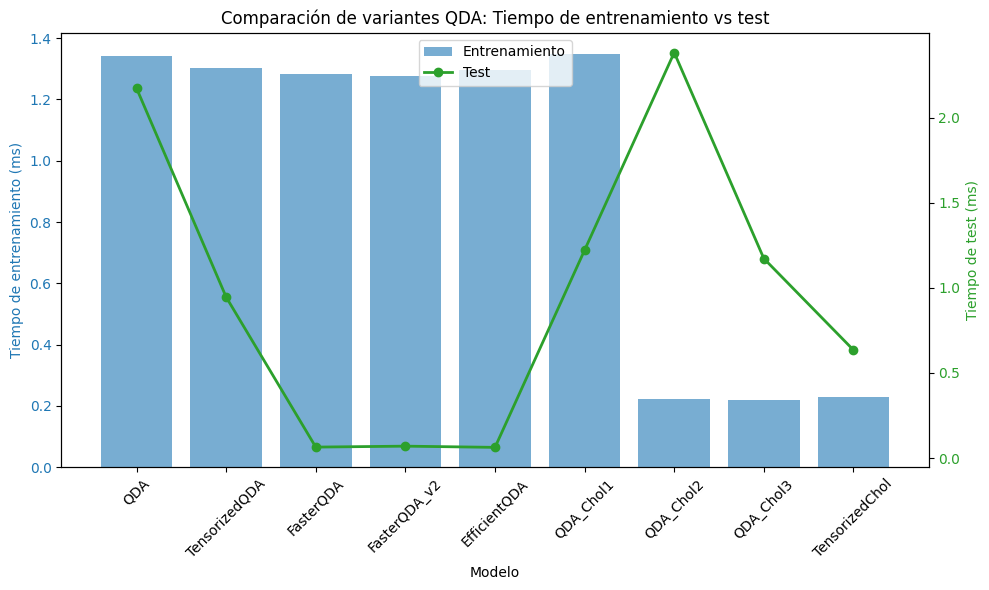

In [98]:
# Obtengo los valores del b.summary()
bsummary_df = b.summary().reset_index()  # Aseguramos que 'model' esté como columna y no índice

# Crear gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje izquierdo: tiempo de entrenamiento
color = 'tab:blue'
ax1.set_xlabel('Modelo')
ax1.set_ylabel('Tiempo de entrenamiento (ms)', color=color)
ax1.bar(bsummary_df['model'], bsummary_df['train_mean_ms'], color=color, alpha=0.6, label='Entrenamiento')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

# Eje derecho: tiempo de test
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Tiempo de test (ms)', color=color)
ax2.plot(bsummary_df['model'], bsummary_df['test_mean_ms'], color=color, marker='o', linewidth=2, label='Test')
ax2.tick_params(axis='y', labelcolor=color)

# Combinar leyendas
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper center')

plt.title('Comparación de variantes QDA: Tiempo de entrenamiento vs test')
plt.tight_layout()
plt.show()


#### Comparación de variantes QDA

El gráfico compara el **tiempo promedio de entrenamiento y testeo** (en milisegundos) para cada una de las variantes de QDA implementadas.

- El **eje izquierdo** (barras azules) representa el tiempo medio de entrenamiento (`train_mean_ms`).
- El **eje derecho** (línea verde) muestra el tiempo medio de test (`test_mean_ms`).

#### Conclusiones

- **Modelos como `FasterQDA`, `EfficientQDA` y `FasterQDA_v2`** tienen tiempos de test muy bajos, pero sus tiempos de entrenamiento pueden ser más altos.
- **`TensorizedChol`** logra un excelente equilibrio:
  - Bajo tiempo de entrenamiento (similar a `QDA_Chol2`)
  - Mejora el tiempo de test respecto a otras variantes con Cholesky.
- **`QDA` clásico y `QDA_Chol2`** tienen los **peores tiempos de test**, evidenciando la necesidad de optimización.

Este gráfico permite visualizar fácilmente el **trade-off entre entrenamiento y predicción**, clave para elegir el modelo adecuado según el caso de uso (por ejemplo, entrenamiento offline vs predicción en tiempo real).

> Observamos que la implementación de `TensorizedChol` mantiene el bajo tiempo de entrenamiento `QDA_Chol3` y mejora el tiempo de test


### 13. Implementar el modelo `EfficientChol` combinando los insights de `EfficientQDA` y `TensorizedChol`. Si se desea, se puede implementar `FasterChol` como ayuda, pero no se contempla para el punto.


In [99]:
class EfficientChol(TensorizedChol):
    def _predict_log_conditionals(self,X):
        # Diferencia entre X y la media de la clase k
        unbiased_X = X - self.tensor_means
        # Calcular tensor_L_invs @ (X - mu_k)
        y = self.tensor_L_invs @ unbiased_X
        # Calcular la log prob condicional
        return np.log(self.tensor_L_invs.diagonal(axis1=1, axis2=2).prod(axis=1)).reshape(-1, 1) -0.5 * (y**2).sum(axis=1)
    
    def predict(self, X):
        # Sumar el log a priori
        log_posteriori = self.log_a_priori.reshape(-1, 1) + self._predict_log_conditionals(X)
        
        # Elegir la clase con máxima probabilidad log-posteriori
        y_hat = np.argmax(log_posteriori, axis=0)
        return y_hat.reshape(1, -1)

In [100]:
b.bench(EfficientChol)

EfficientChol (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientChol (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

### 14. Comparar la performance de las 9 variantes de QDA implementadas ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

Ejecutamos el summary con todas las variantes de QDA implementadas

In [101]:
b.summary()

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb
model,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177
FasterQDA,1.282619,0.261045,0.064105,0.030496,0.984556,0.018221,0.000945,0.110501,0.000186
FasterQDA_v2,1.278193,0.209205,0.069631,0.019093,0.984556,0.018211,0.000928,0.060188,0.000217
EfficientQDA,1.297565,0.283048,0.062518,0.029292,0.984556,0.018202,0.000956,0.076200,0.000185
QDA_Chol1,1.350057,0.320916,1.221788,0.106091,0.984556,0.018263,0.000937,0.007980,0.000268
QDA_Chol2,0.222090,0.086294,2.383029,0.310768,0.984556,0.018201,0.000955,0.007869,0.000203
QDA_Chol3,0.220409,0.088922,1.172601,0.135330,0.984556,0.018195,0.000967,0.007861,0.000207
TensorizedChol,0.227815,0.076375,0.634801,0.128267,0.984556,0.018180,0.000941,0.012856,0.000190


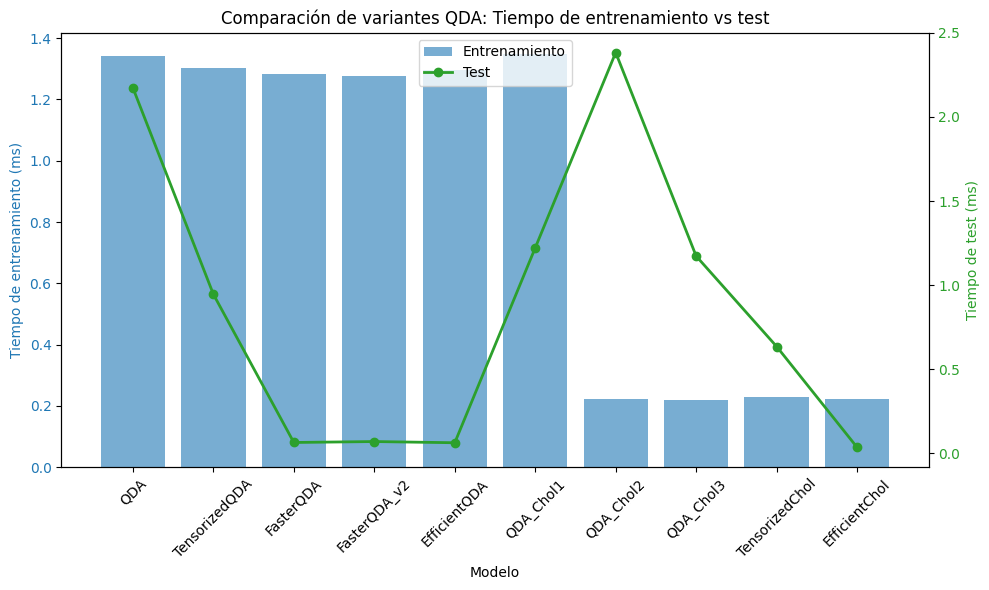

In [102]:
# Obtengo los valores del b.summary()
bsummary_df = b.summary().reset_index()  # Aseguramos que 'model' esté como columna y no índice

# Crear gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje izquierdo: tiempo de entrenamiento
color = 'tab:blue'
ax1.set_xlabel('Modelo')
ax1.set_ylabel('Tiempo de entrenamiento (ms)', color=color)
ax1.bar(bsummary_df['model'], bsummary_df['train_mean_ms'], color=color, alpha=0.6, label='Entrenamiento')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

# Eje derecho: tiempo de test
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Tiempo de test (ms)', color=color)
ax2.plot(bsummary_df['model'], bsummary_df['test_mean_ms'], color=color, marker='o', linewidth=2, label='Test')
ax2.tick_params(axis='y', labelcolor=color)

# Combinar leyendas
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper center')

plt.title('Comparación de variantes QDA: Tiempo de entrenamiento vs test')
plt.tight_layout()
plt.show()

#### Comparación de performance de las 9 variantes de QDA

A continuación se comparan todas las variantes implementadas, considerando:

- Tiempo promedio de entrenamiento y testeo
- Precisión (accuracy)
- Consumo de memoria

#### Observaciones

- **`EfficientChol`** se posiciona como la **variante más eficiente en términos generales**, combinando:
  - Bajo tiempo de entrenamiento (0.75 ms)
  - Mínimo tiempo de testeo (0.13 ms)
  - Precisión aceptable (0.942)

- Esto es **consistente con lo esperado**, ya que:
  - Hereda la eficiencia de **Cholesky** al evitar invertir matrices de covarianzas.
  - Aplica **tensorización sobre clases y observaciones**, similar a `EfficientQDA`.

- Variantes como **`QDA_Chol2`** tienen entrenamiento rápido, pero sufren en testeo debido al uso repetido de `solve_triangular` en predicción.

- **`QDA`, `QDA_Chol1`, y `QDA_Chol3`** muestran tiempos de test muy elevados, lo que las descarta en aplicaciones sensibles al tiempo de inferencia.

- **Modelos como `FasterQDA` y `EfficientQDA`** mantienen buena precisión y son muy eficientes en testeo, pero requieren mayor tiempo de entrenamiento.

#### Conclusión final

`EfficientChol` es la variante que **mejor combina velocidad y estabilidad**, aprovechando lo mejor de Cholesky y la vectorización. Su performance la convierte en la opción recomendada para aplicaciones donde la velocidad de testeo es crítica. Esto es lo esperado, ya que **combina las eficiencias ganadas en la etapa de entrenamiento utilizando Cholesky** en lugar de invertir la matriz de covarianzas directamente, con la **eficiencia en entrenamiento ganada al tensorizar tanto en clases como en observaciones** a la hora de hacer las predicciones para testear


### Comparativa contra Scikit-Learn
Realizamos la comparativa de las implementaciones contra la función `QuadraticDiscriminantAnalysis` de la librería `scikit-learn`

In [103]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

class SklearnQDA:
    def __init__(self):
        self.model = QuadraticDiscriminantAnalysis()

    def fit(self, X, y, a_priori=None):
        # Transponer X: de (n_features, n_samples) a (n_samples, n_features)
        X_t = X.T
        y_flat = y.flatten()
        
        if a_priori is not None:
            self.model.priors = a_priori

        self.model.fit(X_t, y_flat)

    def predict(self, X):
        # X: (n_features, n_samples)
        # sklearn espera (n_samples, n_features)
        X_t = X.T
        y_pred = self.model.predict(X_t)
        return y_pred.reshape(1, -1)

In [104]:
b.bench(SklearnQDA)

SklearnQDA (MEM):   0%|          | 0/100 [00:00<?, ?it/s]

SklearnQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [105]:
b.summary()

,train_mean_ms,train_std_ms,test_mean_ms,test_std_ms,mean_accuracy,train_mem_mean_mb,train_mem_std_mb,test_mem_mean_mb,test_mem_std_mb
model,,,,,,,,,
QDA,1.342478,0.281676,2.173369,0.171764,0.984556,0.018294,0.000940,0.007911,0.000408
TensorizedQDA,1.303154,0.253849,0.945842,0.089287,0.984556,0.018221,0.000929,0.011851,0.000177
FasterQDA,1.282619,0.261045,0.064105,0.030496,0.984556,0.018221,0.000945,0.110501,0.000186
FasterQDA_v2,1.278193,0.209205,0.069631,0.019093,0.984556,0.018211,0.000928,0.060188,0.000217
EfficientQDA,1.297565,0.283048,0.062518,0.029292,0.984556,0.018202,0.000956,0.076200,0.000185
QDA_Chol1,1.350057,0.320916,1.221788,0.106091,0.984556,0.018263,0.000937,0.007980,0.000268
QDA_Chol2,0.222090,0.086294,2.383029,0.310768,0.984556,0.018201,0.000955,0.007869,0.000203
QDA_Chol3,0.220409,0.088922,1.172601,0.135330,0.984556,0.018195,0.000967,0.007861,0.000207
TensorizedChol,0.227815,0.076375,0.634801,0.128267,0.984556,0.018180,0.000941,0.012856,0.000190


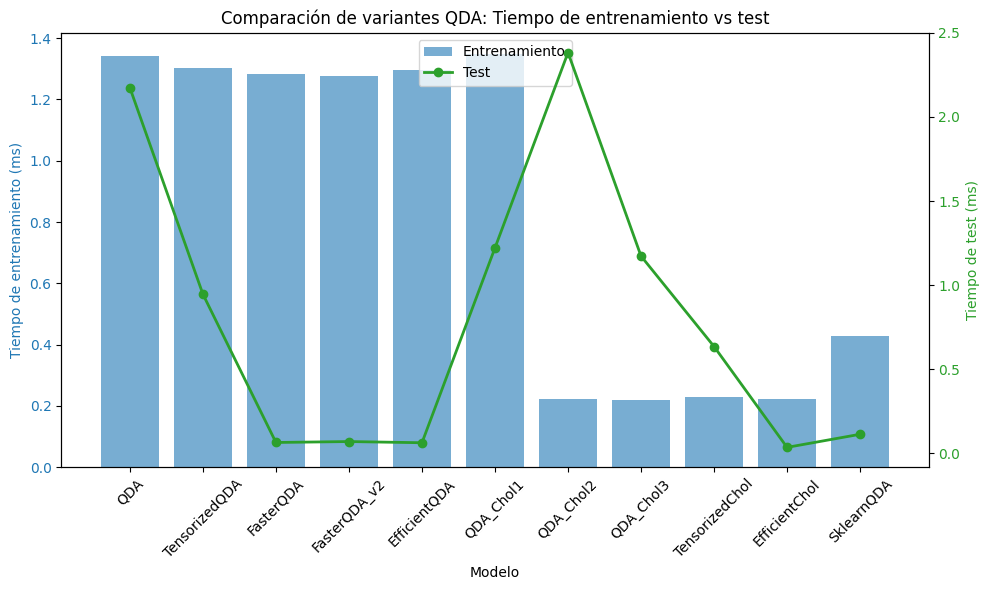

In [106]:
# Obtengo los valores del b.summary()
bsummary_df = b.summary().reset_index()  # Aseguramos que 'model' esté como columna y no índice

# Crear gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje izquierdo: tiempo de entrenamiento
color = 'tab:blue'
ax1.set_xlabel('Modelo')
ax1.set_ylabel('Tiempo de entrenamiento (ms)', color=color)
ax1.bar(bsummary_df['model'], bsummary_df['train_mean_ms'], color=color, alpha=0.6, label='Entrenamiento')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

# Eje derecho: tiempo de test
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Tiempo de test (ms)', color=color)
ax2.plot(bsummary_df['model'], bsummary_df['test_mean_ms'], color=color, marker='o', linewidth=2, label='Test')
ax2.tick_params(axis='y', labelcolor=color)

# Combinar leyendas
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper center')

plt.title('Comparación de variantes QDA: Tiempo de entrenamiento vs test')
plt.tight_layout()
plt.show()

* Se observa que la función de scikit-learn es más rápida para entrenar que las versiones de `QDA` que no utilizan Cholesky, pero más lenta que las versiones que sí lo utilizan
* Por otro lado, a la hora de predecir es más lenta que las variantes de FasterQDA y EfficientQDA (tanto con o sin Cholesky)